# Evaluation: *benchmark* data experiments

Here we process the results of our benchmark data experiments.

In [1]:
# External modules.
from matplotlib import colormaps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os

# Internal modules.
from setup.directories import img_path
from setup.results import my_ext
from setup.utils import makedir_safe

In [2]:
# Make a directory to store images, if one doesn't exist already.
makedir_safe(img_path)

In [3]:
# Specify an experiment name, get relevant information.
exp_name = "exp:cifar100"
data_name = exp_name.split(":")[1]
experiment = mlflow.get_experiment_by_name(name=exp_name)
print("Experiment_id: {}".format(experiment.experiment_id))
#print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))
exp_id = experiment.experiment_id

Experiment_id: 870556255219925522
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1705042030346


In [4]:
# Take a look at the "runs" associated with the selected experiment.
runs = mlflow.search_runs(exp_id)
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Columns: 456 entries, run_id to tags.mlflow.source.git.repoURL
dtypes: datetime64[ns, UTC](2), float64(307), object(147)
memory usage: 894.3+ KB


In [5]:
# Look at all runs with a non-null setting (basically any param is fine).
runs_notnull = runs[runs["params.bs_tr"].notnull()]
runs_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 249
Columns: 456 entries, run_id to tags.mlflow.source.git.repoURL
dtypes: datetime64[ns, UTC](2), float64(307), object(147)
memory usage: 892.6+ KB


In [6]:
# First, let's make a copy of the whole data frame to be safe.
runs_notnull_parsed = runs_notnull.copy()

# Next, grab the column to be parsed, populate some lists, turn into Series objects.
mth_family_names = []
mth_numbers = []
trial_numbers = []
for run_name in runs_notnull_parsed["tags.mlflow.runName"]:
    pc_check, mth_details = run_name.split(":")
    if pc_check == "parent":
        raise ValueError("Something is wrong; should not have any parent runs here.")
    elif pc_check == "child":
        mth_family_name, mth_number, trial_info = mth_details.split("-")
        mth_family_names += [mth_family_name]
        mth_numbers += [int(mth_number)]
        trial_numbers += [int(trial_info[1:])]
    else:
        raise ValueError("Something is wrong; did not find a child run.")

# Try adding these columns to the right-most side of the DataFrame of interest.
original_width = runs_notnull_parsed.shape[1]
runs_notnull_parsed.insert(original_width, "trial_number", trial_numbers)
runs_notnull_parsed.insert(original_width, "mth_number", mth_numbers)
runs_notnull_parsed.insert(original_width, "mth_family", mth_family_names)
runs_notnull_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 249
Columns: 459 entries, run_id to trial_number
dtypes: datetime64[ns, UTC](2), float64(307), int64(2), object(148)
memory usage: 898.4+ KB


In [7]:
# Check family names.
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
print("- - Unique trial numbers:", unique_trial_numbers)
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
print("- - Unique family names:", unique_family_names)
# Check method numbers.
for mth_family_name in unique_family_names:
    idx_methods = runs_tocheck["mth_family"] == mth_family_name
    runs_tocheck_methods = runs_tocheck[idx_methods]
    print("- - - Method number counts ({}):".format(mth_family_name))
    print(runs_tocheck_methods["mth_number"].value_counts())

- - Unique trial numbers: [0 1 2 3 4]
- - Unique family names: ['CVaR' 'DRO' 'Ishida' 'SoftAD' 'Tilted']
- - - Method number counts (CVaR):
mth_number
9    5
8    5
7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: count, dtype: int64
- - - Method number counts (DRO):
mth_number
9    5
8    5
7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: count, dtype: int64
- - - Method number counts (Ishida):
mth_number
9    5
8    5
7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: count, dtype: int64
- - - Method number counts (SoftAD):
mth_number
9    5
8    5
7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: count, dtype: int64
- - - Method number counts (Tilted):
mth_number
9    5
8    5
7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: count, dtype: int64


In [8]:
# Metric names.
metrics = [c[8:] for c in runs_notnull_parsed.columns if c.startswith("metrics")]

# Specify the metric to be used for validation.
metric_for_validation = "acc_va" #"loss_va" #"acc_va"
if metric_for_validation not in metrics:
    raise ValueError("The selected metric {} is not available...".format(metric_for_validation))
print("All metric names:", metrics)
if metric_for_validation == "loss_va":
    do_argmax = False
elif metric_for_validation == "acc_va":
    do_argmax = True
else:
    raise ValueError("Unexpected metric for validation.")

# Function in charge of selecting the best candidate.
def get_best_idx(metric_history_list, do_argmax=do_argmax):
    '''
    Given a list of sequences, this function returns the index
    of the "best" sequence by taking an *argmax/min* over the *final* values
    of these sequences (e.g., final accuracy, loss, etc.).
    '''
    list_len = len(metric_history_list)
    if list_len < 1:
        raise ValueError("No metric histories provided.")
    elif list_len == 1:
        return 0
    else:
        values_to_compare = []
        for mh in metric_history_list:
            values_to_compare += [mh[-1]] # use last step.
        if do_argmax:
            return np.argmax(np.array(values_to_compare)).item()
        else:
            return np.argmin(np.array(values_to_compare)).item()


All metric names: ['abc_64_va', 'abc_29_va', 'abc_98_te', 'abc_51_va', 'abc_13_tr', 'abc_15_tr', 'abc_20_va', 'abc_10_va', 'abc_81_tr', 'abc_80_va', 'abc_44_va', 'abc_62_te', 'abc_15_te', 'abc_44_te', 'abc_99_va', 'abc_31_va', 'abc_49_te', 'abc_28_te', 'abc_78_te', 'abc_93_tr', 'abc_0_tr', 'abc_99_te', 'model_norm', 'abc_24_tr', 'abc_92_va', 'abc_62_va', 'abc_74_va', 'abc_91_te', 'abc_53_tr', 'abc_7_te', 'abc_40_va', 'abc_70_va', 'abc_5_tr', 'abc_36_va', 'abc_84_va', 'abc_39_va', 'abc_73_tr', 'abc_70_te', 'abc_68_va', 'abc_32_tr', 'abc_75_te', 'abc_16_tr', 'abc_5_te', 'abc_7_va', 'loss_tr', 'abc_33_te', 'abc_34_tr', 'abc_30_va', 'abc_89_te', 'abc_53_va', 'abc_35_va', 'abc_40_te', 'abc_36_te', 'abc_18_te', 'abc_97_va', 'abc_31_te', 'abc_33_va', 'abc_41_va', 'abc_0_te', 'abc_12_tr', 'abc_55_te', 'abc_67_tr', 'abc_81_va', 'abc_96_tr', 'abc_97_te', 'abc_9_tr', 'abc_54_tr', 'abc_88_va', 'abc_25_va', 'abc_83_te', 'abc_66_tr', 'abc_29_tr', 'abc_66_va', 'abc_15_va', 'abc_20_tr', 'abc_45_tr', '

To proceed, we set up a loop very similar to the one we just did for our sanity checks, but this time we grab *candidate run IDs*, use these to read in the *metric history*, and then finally choose a *representative run ID* for each combination of (noise level, trial, method family).

In [9]:
# Set up a dictionary where we can store "representative" run IDs and results for each method family.
dict_of_run_ids = {m:[] for m in unique_family_names}

# Get the loop going, with a "client" for reading in metric history.
client = mlflow.tracking.MlflowClient()
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
for trial_number in unique_trial_numbers:
    runs_tocheck_bytrial = runs_tocheck[runs_tocheck["trial_number"] == trial_number]
    for mth_family_name in unique_family_names:
        idx_candidates = runs_tocheck_bytrial["mth_family"] == mth_family_name
        runs_tocheck_byfamily = runs_tocheck_bytrial[idx_candidates]
        candidate_run_ids = runs_tocheck_byfamily.run_id
        #print(type(candidate_run_ids), len(candidate_run_ids))
        #print(candidate_run_ids)
        if len(candidate_run_ids) == 1:
            # If only one setting, no need to check validation data.
            best_idx = 0
        elif len(candidate_run_ids) > 1:
            # When have multiple settings, use the specified metric for validation.
            metric_history_list = [
                [s.value for s in client.get_metric_history(r, metric_for_validation)] for r in candidate_run_ids
            ]
            best_idx = get_best_idx(metric_history_list)
        else:
            raise ValueError("No candidate runs...!")
            
        dict_of_run_ids[mth_family_name] += [candidate_run_ids.iloc[best_idx]]
                
print(dict_of_run_ids)

{'CVaR': ['007ed5dd48bd4364aef479fe00ce0536', 'b3f45700bc454d59bfe27d88ccd9632b', '49cb77601aee48558d70f666b15427c4', '090e3d44e85f494ba0c9d510395fa838', 'e605e9f7961d4db8820919523bc72c87'], 'DRO': ['2d1b695ce4f6410ba4310e120b4c74fe', '28d251384c444ac493a512958ffec41b', '085d741de5e94f24bc9cad03b0df37b2', '2b1212153eeb47ce8faa3533190db816', '626d2339b69a4b0ab25e6889c6bce10a'], 'Ishida': ['f2dad8218f924968a615aa8fe29767bf', '610a1d6c2da24f2bbf264fd084930e60', '7d6ae0cd972e44afadeaa77d0586b24e', '4dbf4b76807343d798a875b71dbf33c5', '168a23db1e544351954baacbad548ced'], 'SoftAD': ['63d05ffffe874adb871b16f5d1d2a8d4', '8a1c60d5ac304e939bef38612bd323e5', 'f5e10feca0d342c4a392776127119eaa', '58215f1faa924930b9014e1c70785453', '12e233ccd864460d92b4e2d3160f8ced'], 'Tilted': ['24d8e65e405c414886e5638de68b6f8f', '87fca41ea56a4d569cf44fd725e83310', '68837ce844c740ac81cb9b77d4776c88', 'f51c143d062a453d9f9e1b8f67624a35', 'b3c397c9b0e54733935edfdcf413d535']}


With all the final candidate run IDs in place, all that remains is to get the relevant metric histories for each, and plot them in a clear, readable fashion.

(CVaR, params.quantile_level)
mean: 0.28 stdev: 0.130384048104053
226                    0.4
228                    0.4
234    0.30000000000000004
237                    0.2
240                    0.1
Name: params.quantile_level, dtype: object
(DRO, params.radius)
mean: 0.0 stdev: 0.0
195    0.0
196    0.0
197    0.0
198    0.0
199    0.0
Name: params.radius, dtype: object
(Ishida, params.flood_level)
mean: 0.03200000000000001 stdev: 0.04919349550499537
92    0.12
95    0.01
96    0.01
98    0.01
99    0.01
Name: params.flood_level, dtype: object
(SoftAD, params.theta)
mean: 0.154 stdev: 0.13145341380123984
15    0.25
16    0.25
18    0.25
47    0.01
49    0.01
Name: params.theta, dtype: object
(Tilted, params.tilt)
mean: 0.0 stdev: 0.0
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: params.tilt, dtype: object
final values (ave, loss_tr)
  0.006750725238816813 (CVaR)
  0.002870475687086582 (DRO)
  0.0392538009211421 (Ishida)
  0.14614612576551736 (SoftAD)
  0.0033140779531

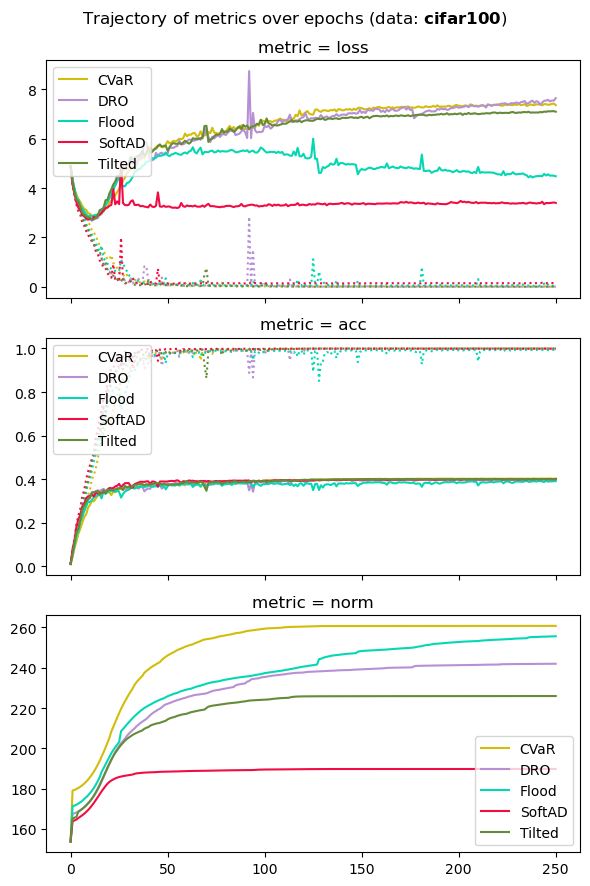

In [10]:
# List of metrics to use for each subplot.
metrics_to_use_list = [["loss_tr", "loss_te"], ["acc_tr", "acc_te"], ["model_norm"]]

# Color setup.
colors_by_method = {
    "CVaR": "xkcd:mustard yellow",
    "DRO": "xkcd:pale purple",
    "ERM": "xkcd:black",
    "Ishida": "xkcd:aquamarine",
    "SoftAD": "xkcd:pinkish red",
    "Tilted": "xkcd:moss green"
}

# Name setup.
plotnames_by_method = {
    "CVaR": "CVaR",
    "DRO": "DRO",
    "ERM": "ERM",
    "Ishida": "Flood",
    "SoftAD": "SoftAD",
    "Tilted": "Tilted"
}

# Extra details to check.
extras_by_method = {
    "CVaR": ["params.quantile_level"],
    "DRO": ["params.radius"],
    "ERM": [],
    "Ishida": ["params.flood_level"],
    "SoftAD": ["params.theta"],
    "Tilted": ["params.tilt"]
}


client = mlflow.tracking.MlflowClient()
# Prepare the figure (one sub-plot per metric, but with tr and te on same plot).
fig, axes = plt.subplots(3, figsize=(6, 3*len(metrics_to_use_list)), sharex=True)

# Get the run IDs selected for all methods at this noise level.
best_run_ids = dict_of_run_ids

# For each method, look at extra info of interest.
for mth_family_name in best_run_ids:
    extras_list = extras_by_method[mth_family_name]
    if len(extras_list) > 0:
        df = runs_notnull_parsed[runs_notnull_parsed["run_id"].isin(best_run_ids[mth_family_name])]
        for extra_name in extras_list:
            print("({}, {})".format(mth_family_name, extra_name))
            print("mean:", df[extra_name].astype(float).mean(),
                  "stdev:", df[extra_name].astype(float).std())
            print(df[extra_name])

# Get a loop going.
for ax, metrics_to_use in zip(axes, metrics_to_use_list):

    # Process things for the first metric (always at least one).
    metric_to_use = metrics_to_use[0] # set metric name by hand.
    print("final values (ave, {})".format(metric_to_use))
    for mth_family_name in best_run_ids:
        # Get metrics for the representative candidates.
        metric_array = [
            [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array, and plot the average over trials.
        metric_array = np.array(metric_array)
        #print("DBDB", mth_family_name, metric_to_use, metric_array.shape)
        
        if metrics_to_use[0] == "model_norm":
            linestyle_to_use = "solid"
            label_to_use = plotnames_by_method[mth_family_name]
        else:
            linestyle_to_use = "dotted"
            label_to_use = None
        ax.plot(
            np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
            color=colors_by_method[mth_family_name],
            linestyle=linestyle_to_use,
            label=label_to_use
        )
        print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))

    # If have more than one metric, plot the second one, but no more.
    if len(metrics_to_use) > 1:
        metric_to_use = metrics_to_use[1] # set metric name by hand.
        print("final values (ave, {})".format(metric_to_use))
        for mth_family_name in best_run_ids:
            # Get metrics for the representative candidates.
            metric_array = [
                [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
            ]
            # Organize into a numpy array, and plot the average over trials.
            metric_array = np.array(metric_array)
            label_to_use = plotnames_by_method[mth_family_name]
            ax.plot(
                np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
                color=colors_by_method[mth_family_name],
                linestyle="solid",
                label=label_to_use
            )
            print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))
    if len(metrics_to_use) > 2:
        raise ValueError("Expected one or two metrics, no more/less.")

    if metrics_to_use[0] == "loss_tr" and data_name == "svhn":
        ax.set(ylim=(-0.05, 1.5))

    # Having plotted for all methods, configure other parts of the current sub-plot.
    metric_name_for_plot = metrics_to_use[0].split("_")[0 if len(metrics_to_use) > 1 else 1]
    ax.set_title("metric = {}".format(metric_name_for_plot))
    ax.legend(loc="best")
    
# Finally, macroscropic settings for the whole figure.
fig.suptitle(
    "Trajectory of metrics over epochs " + r"(data: $\mathbf{"+str(data_name)+"}$)"
)
plt.tight_layout()
fname = os.path.join(img_path, "benchmarks_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

___